## Basic Graph Descriptions

Plots all semantic speech graphs in the dataset for quick inspection and visualisation of graph motifs.
Graphs are described using various graph theoretical measures. Distribution of graph measures across the dataset are plotted.



In [1]:
import warnings
warnings.filterwarnings("ignore")
import networkx as nx
from stanza.server import CoreNLPClient
import os
import os.path as op
import pandas as pd
import sys
sys.path.append(
    '/Users/CN/Documents/Projects/Cambridge/cambridge_language_analysis/')
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import datetime
import glob
import re
import seaborn as sns
import word2vec as w2v
import gensim
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import collections

In [1]:
# SemanticSpeechGraph functions
from compile_graphs_dataset import get_graphs, graph_properties
from graph_analysis_functions import print_bidirectional_edges, print_parallel_edges, get_parallel_edges, central_words, calc_vector_distance, calc_vector_distance_adj, choose_representative_word, find_representative_node_words

In [2]:
# --------------------- Import graphs ---------------------------------------
graph_dir = '/Users/CN/Dropbox/speech_graphs/all_tats'

graphs, filelist = get_graphs(graph_dir)
df = graph_properties(graphs, filelist)

print('Imported and described {0} graphs'.format(df.shape[0]))
df.head()

Imported and described 289 graphs


subj tat  words  sentences  nodes  edges  unconnected  \
0  3138838  10    111          7     16     18            4   
1  3138838  13    129          6     23     20            0   
2  3138838  30    119          8     21     20            2   
3  3138849  10     71          3     13     12            3   
4  3138849  13     97          5     25     20            1   

   average_total_degree  parallel_edges  lsc  ...  max_degree_centrality  \
0              2.250000               0    3  ...               1.000000   
1              1.739130               0    1  ...               0.545455   
2              1.904762               0    1  ...               0.350000   
3              1.846154               1    1  ...               0.250000   
4              1.600000               0    1  ...               0.208333   

   max_degree_node        max_indegree_centrality  \
0             girl                    (girl, 0.4)   
1          the men  (the men, 0.2727272727272727)   
2              man                 (picture, 0.2)   
3            bread                  (bread, 0.25)   
4               it     (bit, 0.08333333333333333)   

        max_outdegree_centrality mean_confidence  std_confidence   density  \
0                    (girl, 0.6)        0.515703        0.254636  0.133333   
1  (the men, 0.2727272727272727)        0.571675        0.255738  0.079051   
2     (man, 0.30000000000000004)        0.501676        0.232276  0.095238   
3                     (it, 0.25)        0.768180        0.198013  0.141026   
4      (it, 0.20833333333333331)        0.497572        0.245393  0.066667   

  diameter average_shortest_path clustering  
0        4              2.291667   0.000000  
1        5              2.375000   0.118538  
2        7              3.204678   0.013033  
3        5              2.333333   0.000000  
4        4              2.266667   0.000000  

[5 rows x 26 columns]

In [6]:
# --------------------- Print nodes and edges ---------------------------------------
for G in graphs:
    print('Nodes: {} \t Edges: {}'.format(len(G.nodes()), G.size()))

Nodes: 16 	 Edges: 18
Nodes: 23 	 Edges: 20
Nodes: 21 	 Edges: 20
Nodes: 13 	 Edges: 12
Nodes: 25 	 Edges: 20
Nodes: 19 	 Edges: 15
Nodes: 18 	 Edges: 15
Nodes: 15 	 Edges: 10
Nodes: 19 	 Edges: 19
Nodes: 16 	 Edges: 14
Nodes: 18 	 Edges: 18
Nodes: 27 	 Edges: 24
Nodes: 19 	 Edges: 14
Nodes: 23 	 Edges: 33
Nodes: 20 	 Edges: 22
Nodes: 23 	 Edges: 24
Nodes: 19 	 Edges: 16
Nodes: 17 	 Edges: 22
Nodes: 24 	 Edges: 16
Nodes: 11 	 Edges: 12
Nodes: 22 	 Edges: 20
Nodes: 23 	 Edges: 20
Nodes: 26 	 Edges: 29
Nodes: 13 	 Edges: 15
Nodes: 18 	 Edges: 18
Nodes: 10 	 Edges: 13
Nodes: 3 	 Edges: 2
Nodes: 7 	 Edges: 5
Nodes: 25 	 Edges: 27
Nodes: 15 	 Edges: 15
Nodes: 24 	 Edges: 18
Nodes: 13 	 Edges: 10
Nodes: 23 	 Edges: 16
Nodes: 19 	 Edges: 17
Nodes: 15 	 Edges: 14
Nodes: 21 	 Edges: 18
Nodes: 16 	 Edges: 17
Nodes: 9 	 Edges: 8
Nodes: 9 	 Edges: 9
Nodes: 19 	 Edges: 17
Nodes: 19 	 Edges: 15
Nodes: 18 	 Edges: 18
Nodes: 30 	 Edges: 26
Nodes: 21 	 Edges: 18
Nodes: 17 	 Edges: 19
Nodes: 22 	 Edges:

In [7]:
# --------------------- Calculate central node word2vec distance ---------------------------------------
df['distance'] = np.nan
frequent_words = []
# Initialise Word2Vec model
model = w2v.load('word2vec_data/text8.bin')
for tat in df.tat.cat.categories:
    most_frequent_word, tat_words_filtered = central_words(df, tat)
    frequent_words.append(most_frequent_word)
    # ---- Calculate distance between to most frequent word for all words ---
    distance = calc_vector_distance(
        most_frequent_word, tat_words_filtered, model)
    row_indices = df.index[df.tat == tat].tolist()
    df.loc[row_indices, 'distance'] = distance

Word is not in word2vec vocabulary: everyones. Setting distance as nan.
Word is not in word2vec vocabulary: lamppost. Setting distance as nan.


In [6]:

# # --------------------- Calculate word2vec distance between adjacent nodes (distance_mean) --------------
df['distance_mean'] = np.nan
# # Initialise Word2Vec model
model = w2v.load('word2vec_data/text8.bin')
#
# --- Find representative word in every node ---
# concatenate node words of every graph, with graphs seperated by \n\n to be split into seperate sentences by CoreNLP
nodes_allGraphs = ''
for G in graphs:
    nodes = list(G.nodes())
    nodes = (' ').join(nodes)
    nodes_allGraphs = nodes_allGraphs + nodes + '\n\n'
#
# part-of-speech tag node words
with CoreNLPClient(properties={'annotators': 'tokenize,ssplit,pos,lemma', 'ssplit.newlineIsSentenceBreak': 'two'}, be_quiet=True) as client:
    doc = client.annotate(nodes_allGraphs)
#
# Get dictionary with one representative words for every node entry on the basis of pos tags
representative_node_words = find_representative_node_words(
    graphs, doc, quiet=False)
#
# ---- Calculate distance between all adjacent nodes in graph ---
for g, G in enumerate(graphs):
    distance = calc_vector_distance_adj(
        G, model, representative_node_words, quiet=False)
    df['distance_mean'][g] = distance

|| picture: 		0.19008278471673534

he || they: 		0.35387001627165504

they || hard: 		0.3096907014847235

they || tip: 		0.07704149772930152

they || little: 		0.2026880282456596

they || that: 		0.2248039257828552

they || bit: 		0.12202796251341934

somebody || nap: 		0.31397460771126795

bit || image: 		0.1867369886781577

it || feelings: 		0.23306570273269894

hours || working: 		0.2089341069192879

tree || blossom: 		0.3567015390097601

tree || nice: 		0.3547352904538692

tree || boat: 		0.3774161297984148

blossom || its: 		0.04884634605226098

blossom || middle: 		0.07431959474125374

this || picture: 		0.19008278471673534

this || all: 		0.15439630125576936

this || idyllic: 		0.05980837000384206

this || i: 		0.12597972032990906

all || field: 		0.17202473407511853

i || just: 		0.3432540419669558

i || enjoy: 		-0.0536496288316274

i || there: 		0.09404872256249061

i || tranquil: 		0.02306160812440823

i || afternoon: 		0.13712136791941587

image || boat: 		0.151584125952005

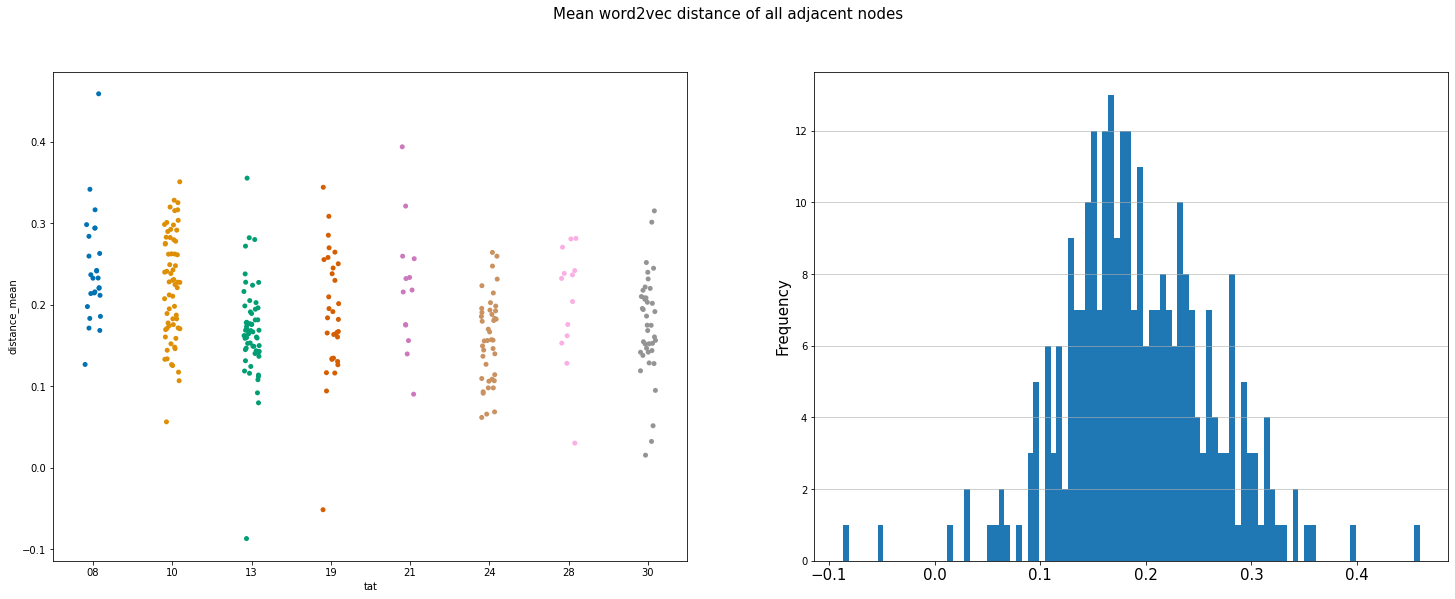

In [7]:

# ----------- Plot -----------
fig = plt.figure(figsize=(25, 9))
plt.suptitle('Mean word2vec distance of all adjacent nodes', fontsize=15)
ax = plt.subplot(1, 2, 1)
sns.stripplot(y='distance_mean', x='tat',
              data=df,
              palette="colorblind",
              )
ax = plt.subplot(1, 2, 2)
plt.hist(df.distance_mean, bins=100)
plt.grid(axis='y', alpha=0.75)
plt.ylabel('Frequency', fontsize=15)
plt.xticks(fontsize=15)
# output_dir = '/Users/CN/Dropbox/speech_graphs/all_tats/figures/'
# output = op.join(output_dir, 'Hist_all_vector_distances' +
#                  '_{0}'.format(str(datetime.date.today())))
# plt.savefig(output)
plt.show()

In [8]:
# ----------- How many parallel edges? -----------
print('{0:f} % have at least one parallel edge. Mean number of parallel edges that are parallel in those: {1:f}'.format(
    len(df[df.parallel_edges > 0]) / len(df) * 100, df[df.parallel_edges > 0].parallel_edges.mean()))

42.214533 % have at least one parallel edge. Mean number of parallel edges that are parallel in those: 1.401639


In [9]:
# ----------- Print Parallel edges -----------

# Print parallel edges
for G in graphs:
    print_parallel_edges(G, quiet=True)

# Get parallel edges (where the sentence matches)
list_of_all_pes = []
for G in graphs:
    parallel_edges = get_parallel_edges(G, same_sentence=True)
    list_of_all_pes.append(parallel_edges)

# Construct dataframe from all collected parallel edges
all_pes = pd.DataFrame(columns=['transcript', 'sent', 'n1', 'relation', 'n2'])
all_pes_df = pd.concat(list_of_all_pes)
all_pes_df.head()

# --- Optional: Save df as csv and manually check parallel edge validity ---
# all_pes_df.to_csv(
#     '/Users/CN/Dropbox/speech_graphs/all_tats/output/parallel_edges.csv')
# --> Manual check of parallel edges suggests majority of parallel edges are valid

-------------------------
7 	i 	would want 	hair
---------------------------------
1 	girl 	holding 	baby
---------------------------------
1 	girl 	is 	baby
---------------------------------
2 	girl 	looks too old to be holding 	baby
---------------------------------
2 	girl 	looks too old 	baby
---------------------------------
5 	you 	want to know 	bit
---------------------------------
5 	you 	want 	bit

======= 3145826-TAT13 =======
---------------------------------
10 	i 	would want 	house
---------------------------------
10 	i 	do not think 	house

======= 3145826-TAT24 =======
---------------------------------
0 	impression 	is 	i
---------------------------------
0 	impression 	(of) [poss] 	i

======= 3145826-TAT30 =======
---------------------------------
1 	i 	can see 	photograph
---------------------------------
2 	i 	think 	photograph
---------------------------------
6 	i 	like 	left
---------------------------------
9 	i 	dislike 	left
---------------------------------
8

transcript  sent   n1           relation           n2
0  3138849-TAT10     2   it         to portray  development
1  3138849-TAT10     2   it           has been  development
0  3138849-TAT30    11  man            smoking    cigarette
1  3138849-TAT30    11  man  could be standing    cigarette
2  3138883-TAT30     4    i   can not make out           it

In [21]:
# ----------- Print bidirectional edges -----------
for g, G in enumerate(graphs):
    # Get bidirectional edges
    print_bidirectional_edges(G, quiet=True)
    # --> All bidirectional edges seem to be valid


======= 3138883-TAT24 =======
---------------------------------
2 	man 	is paying 	respects
---------------------------------
2 	respects 	(of) [poss] 	man

======= 3138883-TAT24 =======
---------------------------------
2 	respects 	(of) [poss] 	man
---------------------------------
2 	man 	is paying 	respects

======= 3138910-TAT24 =======
---------------------------------
1 	hands 	(of) [poss] 	he
---------------------------------
1 	he 	has 	hands

======= 3138910-TAT24 =======
---------------------------------
1 	he 	has 	hands
---------------------------------
1 	hands 	(of) [poss] 	he

======= 3138916-TAT30 =======
---------------------------------
3 	lamppost 	is 	bloke
---------------------------------
2 	bloke 	looks 	lamppost

======= 3138916-TAT30 =======
---------------------------------
2 	bloke 	looks 	lamppost
---------------------------------
3 	lamppost 	is 	bloke

======= 3138932-TAT24 =======
---------------------------------
3 	he 	is holding 	hands
--------------

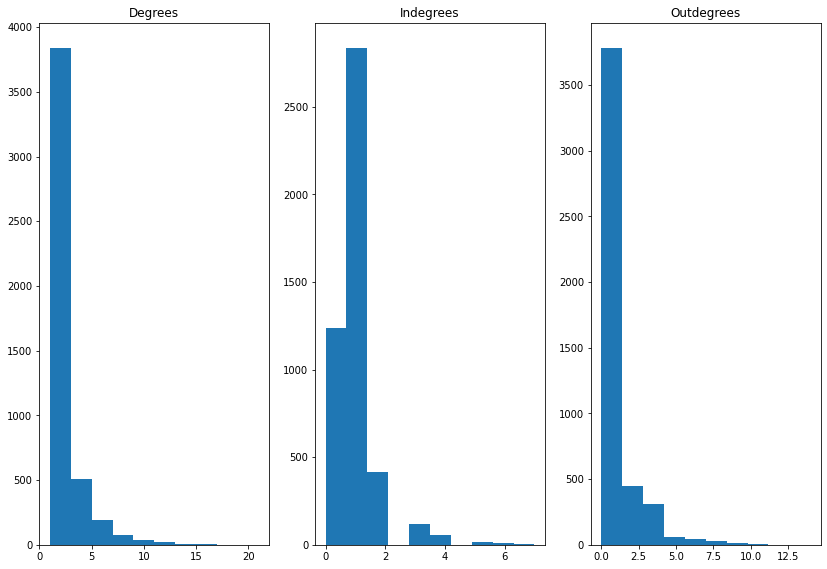

In [9]:
# =================================================================================
# ======================================= Plots ===================================
# =================================================================================
# --------------------- Degree distribution ---------------------------------------
#
degrees = []
in_degrees = []
out_degrees = []
for G in graphs:
    deg = [G.degree(n) for n in G.nodes()]
    degrees.extend(deg)
    outdeg = [G.out_degree(n) for n in G.nodes()]
    out_degrees.extend(outdeg)
    indeg = [G.in_degree(n) for n in G.nodes()]
    in_degrees.extend(indeg)

# Plot
fig = plt.figure(figsize=(14, 9.6))
ax = plt.subplot(1, 3, 1)
plt.hist(degrees)
plt.title('Degrees')
ax = plt.subplot(1, 3, 2)
plt.hist(in_degrees)
plt.title('Indegrees')
ax = plt.subplot(1, 3, 3)
plt.hist(out_degrees)
plt.title('Outdegrees')
# Save figure
output_dir = '/Users/CN/Dropbox/speech_graphs/all_tats/figures/'
output = op.join(output_dir, 'DegreeDistribution_' +
                 '_{0}'.format(str(datetime.date.today())))
plt.savefig(output)
plt.show(block=False)

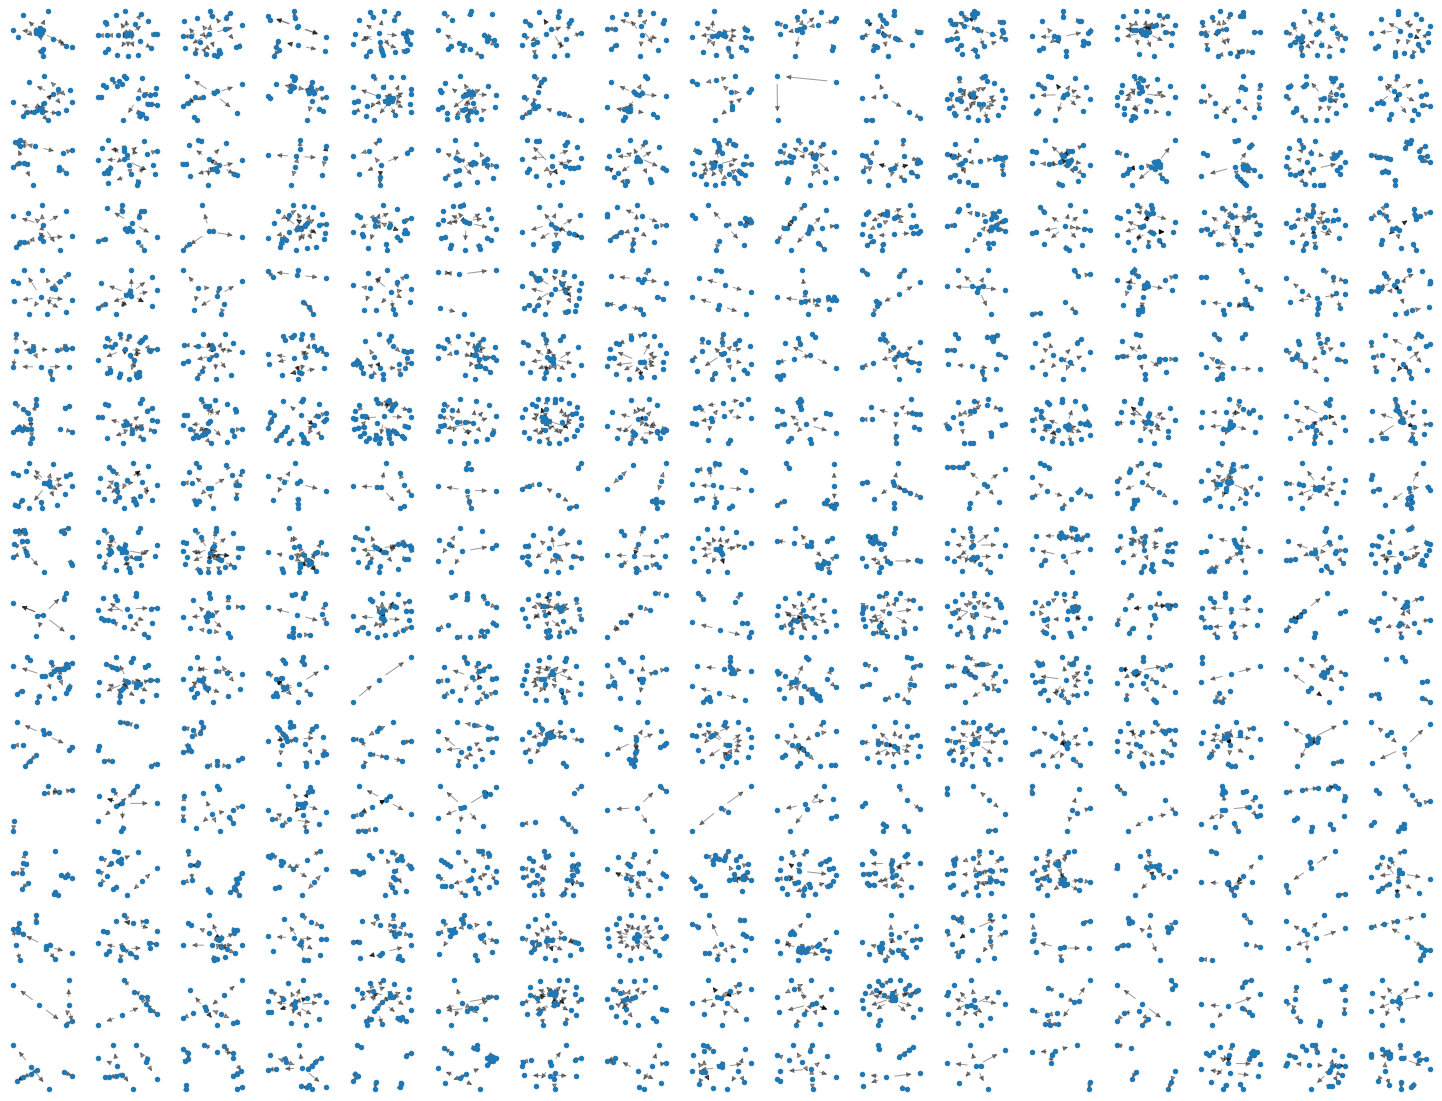

In [10]:
# --------------------- Raster Plot of all Graphs ---------------------------------------
fig = plt.figure(figsize=(25.6, 20))
for g, G in enumerate(graphs):
    ax = plt.subplot(17, 17, g + 1)
    pos = nx.spring_layout(G)
    plt.axis("off")
    nx.draw_networkx_nodes(G, pos, node_size=20)
    nx.draw_networkx_edges(G, pos, alpha=0.4)

# --- Optional: Save plot --- 
# output_dir = '/Users/CN/Dropbox/speech_graphs/all_tats/figures/'
# output = op.join(output_dir, 'GraphsRaster_' +
#                  '_{0}'.format(str(datetime.date.today())))
# plt.savefig(output)
plt.show()

['woman', 'woman', 'she', 'man', 'image', 'she', 'she', 'i', 'man', 'she', 'man', 'she', 'she', 'herself', 'i', 'woman', 'she', 'wife', 'i', 'woman', 'i', 'lady', 'woman', 'image', 'picture', 'man']
['girl', 'bread', 'it', 'woman', 'woman', 'girl', 'girl', 'old', 'girl', 'it', 'picture', 'it', 'lady', 'she', 'girl', 'i', 'i', 'it', 'girl', 'baby', 'i', 'girl', 'she', 'i', 'girl', 'person', 'it', 'i', 'she', 'olden', 'girl', 'woman', 'it', 'woman', 'i', 'i', 'woman', 'she', 'i', 'girl', 'girl', 'girl', 'girl', 'picture', 'girl', 'baby', 'lady', 'woman', 'mom', 'daughter', 'it', 'they', 'she', 'sister', 'i', 'they', 'it', 'she', 'girl', 'girl', 'girl', 'opinion', 'it', 'they', 'baby']
['men', 'it', 'i', 'they', 'man', 'soldiers', 'other', 'i', 'man', 'they', 'they', 'men', 'men', 'i', 'i', 'it', 'men', 'poverty', 'it', 'it', 'people', 'it', 'they', 'it', 'these', 'i', 'i', 'woman', 'i', 'men', 'men', 'black', 'they', 'people', 'i', 'men', 'people', 'he', 'battlefield', 'people', 'i', 'i'

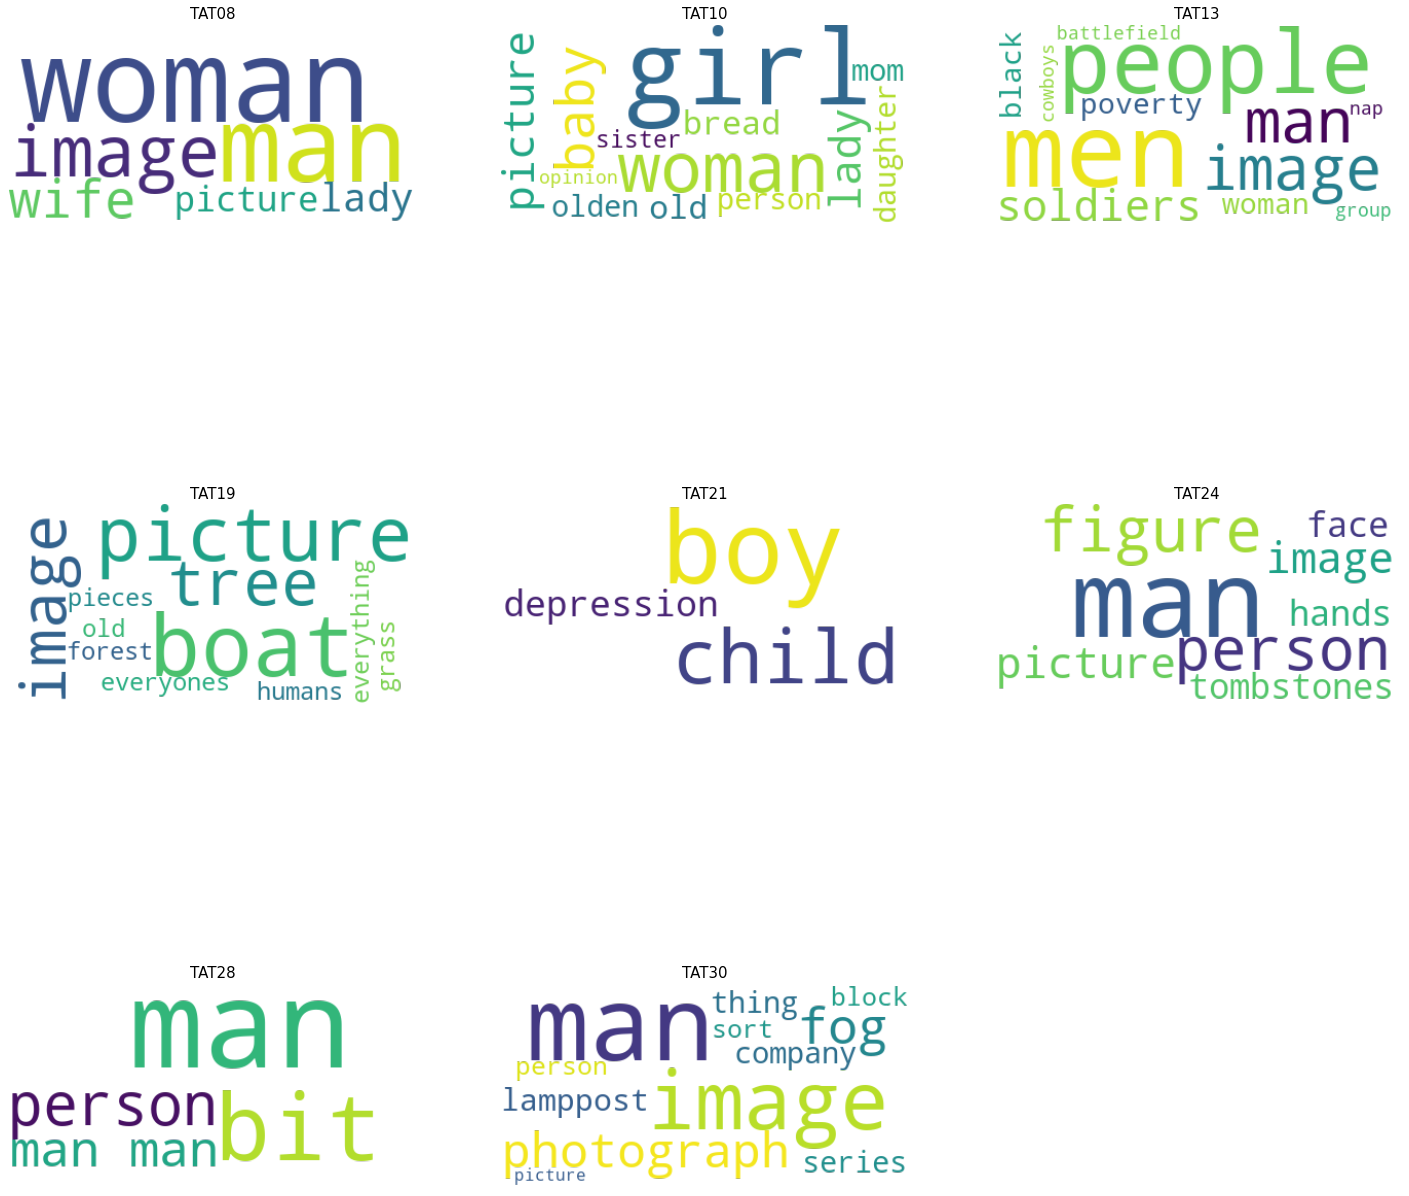

In [22]:
# --------------------- Word clouds ---------------------------------------
fig = plt.figure(figsize=(25, 25))

n_subplots = len(df.tat.cat.categories)
n_cols_subplots = np.ceil(np.sqrt(n_subplots))
n_rows_subplots = np.ceil(n_subplots / n_cols_subplots)
for t, tat in enumerate(df.tat.cat.categories):
    tat_words = df.query('tat == @tat').max_degree_node
    # ---- Get the most frequent word ---
    stop_words = ['the']
    filtered_words = []
    for i, words in enumerate(tat_words):
        # if len(words[0]) > 1
        for word in words.split(' '):
            filtered = []
            if word not in stop_words:
                filtered.append(word)
            all_filtered = (' ').join(filtered)
        filtered_words.append(all_filtered)
    #
    # print(filtered_words)
    tat_words_joined = (' ').join(filtered_words)
    ax = plt.subplot(n_rows_subplots, n_cols_subplots, t + 1)
    wordcloud = WordCloud(background_color=None,
                          mode="RGBA").generate(tat_words_joined)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('TAT' + tat, fontsize=15)
    plt.axis("off")

output_dir = '/Users/CN/Dropbox/speech_graphs/all_tats/figures/'
output = op.join(output_dir, 'WordClouds_' +
                 '_{0}'.format(str(datetime.date.today())))
plt.savefig(output)
plt.show()

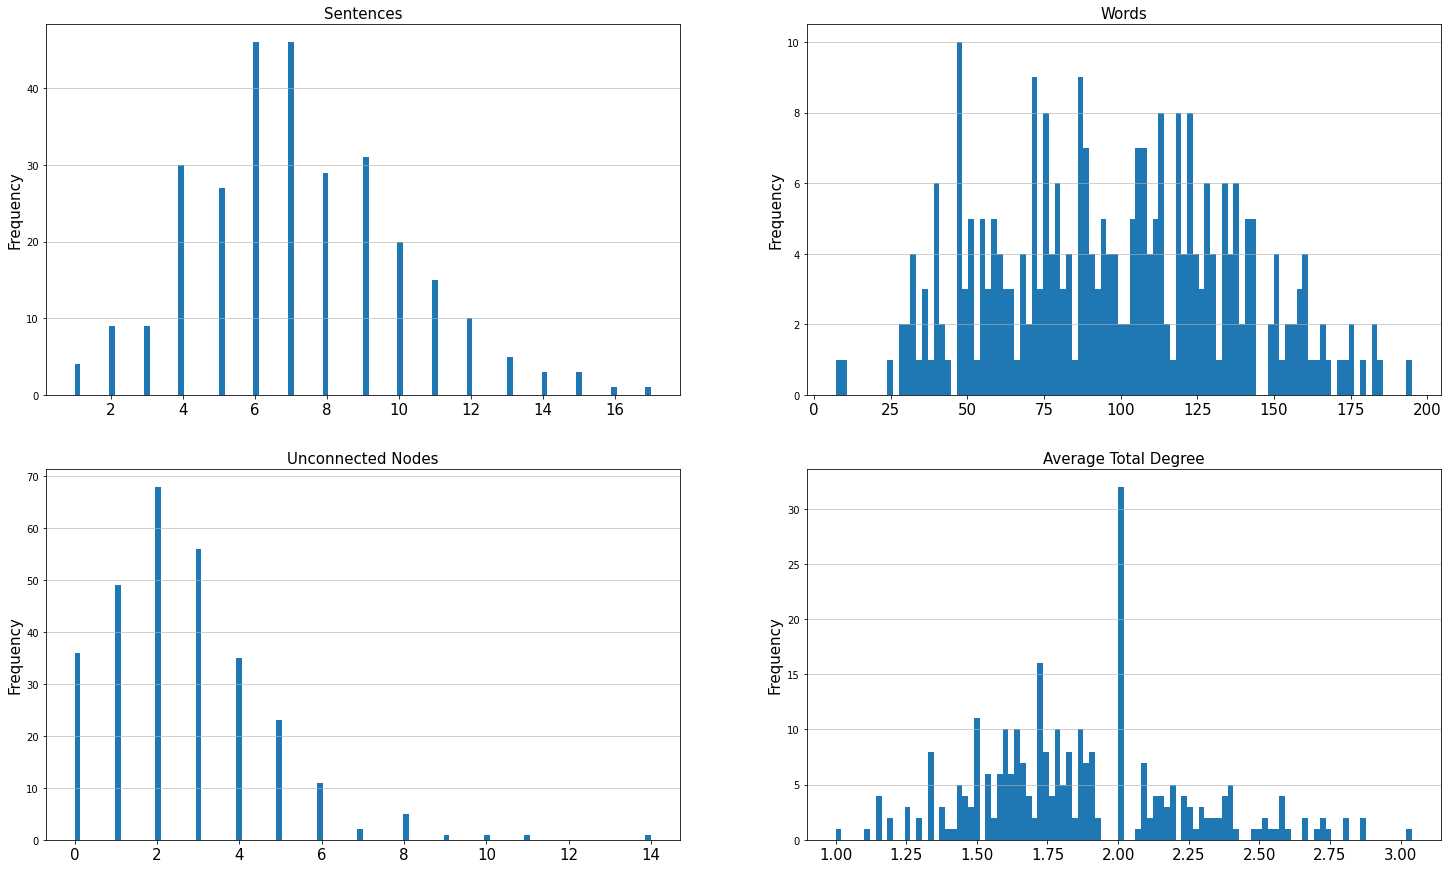

In [23]:

# ----------- Histogram -----------
# Sentences, Words, Unconnected Nodes, Average Total Degree,
fig = plt.figure(figsize=(25, 15))
# Sentences
ax = plt.subplot(2, 2, 1)
plt.hist(df.sentences, bins=100)
plt.grid(axis='y', alpha=0.75)
plt.ylabel('Frequency', fontsize=15)
plt.xticks(fontsize=15)
plt.title('Sentences', fontsize=15)
#
# Words
ax = plt.subplot(2, 2, 2)
plt.hist(df.words, bins=100)
plt.grid(axis='y', alpha=0.75)
plt.ylabel('Frequency', fontsize=15)
plt.xticks(fontsize=15)
plt.title('Words', fontsize=15)
#
# Unconnected Nodes
ax = plt.subplot(2, 2, 3)
plt.hist(df.unconnected, bins=100)
plt.grid(axis='y', alpha=0.75)
plt.ylabel('Frequency', fontsize=15)
plt.xticks(fontsize=15)
plt.title('Unconnected Nodes', fontsize=15)
#
# Average Total Degree
ax = plt.subplot(2, 2, 4)
plt.hist(df.average_total_degree, bins=100)
plt.grid(axis='y', alpha=0.75)
plt.ylabel('Frequency', fontsize=15)
plt.xticks(fontsize=15)
plt.title('Average Total Degree', fontsize=15)
#
# Save figure
output_dir = '/Users/CN/Dropbox/speech_graphs/all_tats/figures/'
output = op.join(output_dir, 'Hist_Basics' +
                 '_{0}'.format(str(datetime.date.today())))
plt.savefig(output)
plt.show(block=False)

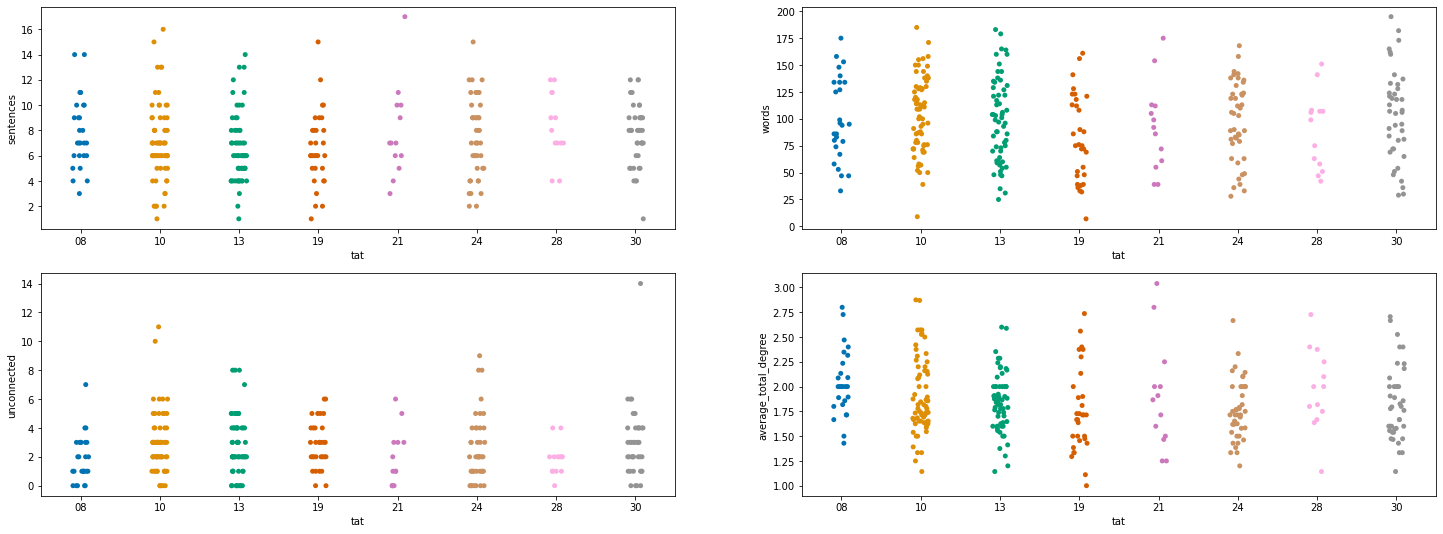

In [24]:
# ----------- stripplot for each TAT -----------
# Sentences, Words, Unconnected Nodes, Average Total Degree,
fig = plt.figure(figsize=(25, 9))
ax = plt.subplot(2, 2, 1)
sns.stripplot(y='sentences', x='tat',
              data=df,
              palette="colorblind",
              )
ax = plt.subplot(2, 2, 2)
sns.stripplot(y='words', x='tat',
              data=df,
              palette="colorblind",
              )
ax = plt.subplot(2, 2, 3)
sns.stripplot(y='unconnected', x='tat',
              data=df,
              palette="colorblind",
              )
ax = plt.subplot(2, 2, 4)
sns.stripplot(y='average_total_degree', x='tat',
              data=df,
              palette="colorblind",
              )

output_dir = '/Users/CN/Dropbox/speech_graphs/all_tats/figures/'
output = op.join(output_dir, 'Hist_TAT_Basics' +
                 '_{0}'.format(str(datetime.date.today())))
plt.savefig(output)
plt.show(block=False)

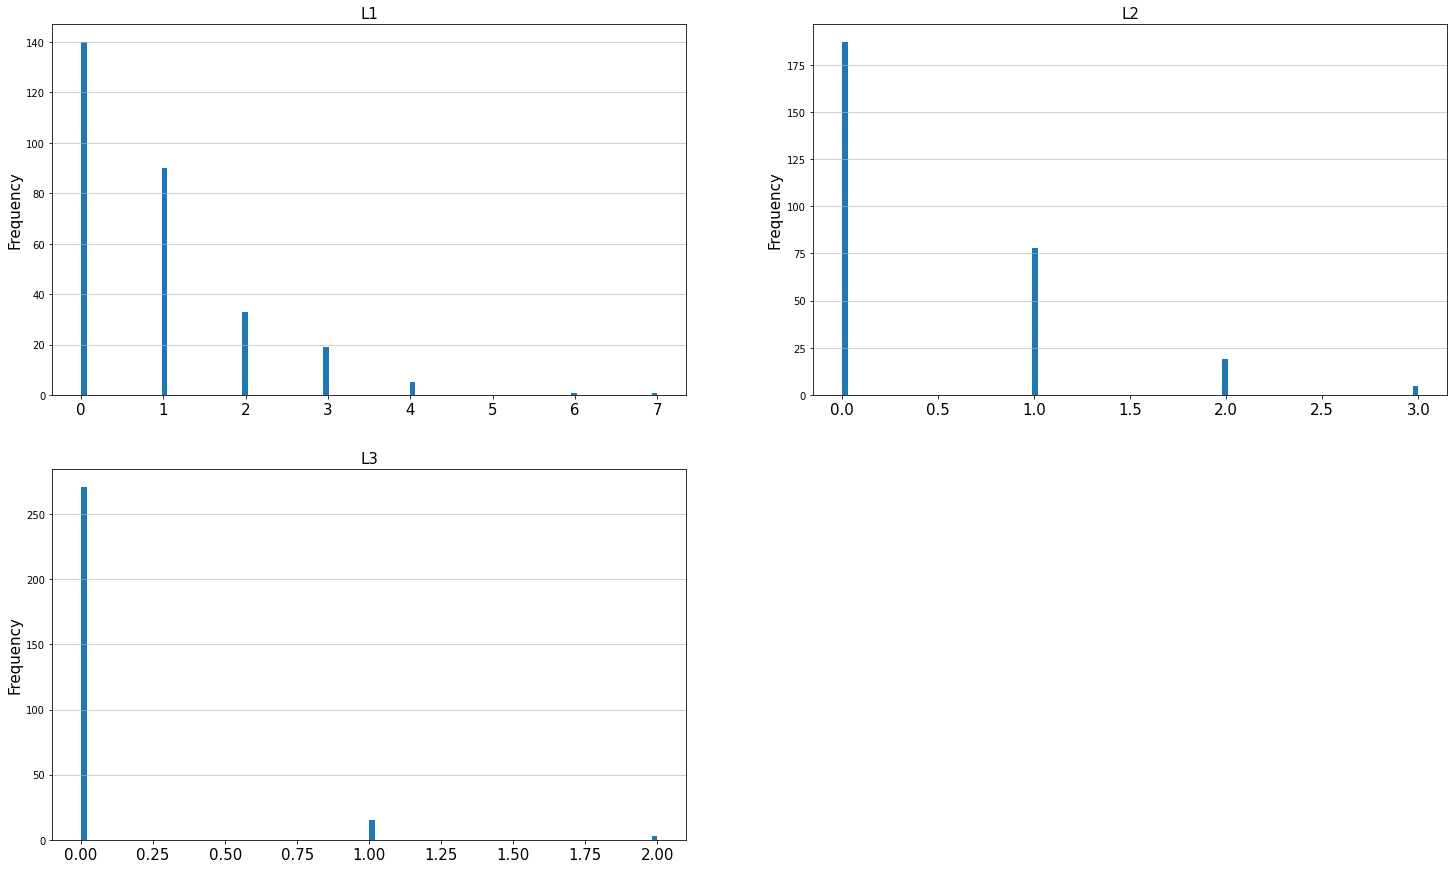

In [34]:
# ----------- Histogram -----------
# L1, L2, L3
fig = plt.figure(figsize=(25, 15))
# L1
ax = plt.subplot(2, 2, 1)
plt.hist(df.L1, bins=100)
plt.grid(axis='y', alpha=0.75)
plt.ylabel('Frequency', fontsize=15)
plt.xticks(fontsize=15)
plt.title('L1', fontsize=15)
#
# L2
ax = plt.subplot(2, 2, 2)
plt.hist(df.L2, bins=100)
plt.grid(axis='y', alpha=0.75)
plt.ylabel('Frequency', fontsize=15)
plt.xticks(fontsize=15)
plt.title('L2', fontsize=15)
#
# L3
ax = plt.subplot(2, 2, 3)
plt.hist(df.L3, bins=100)
plt.grid(axis='y', alpha=0.75)
plt.ylabel('Frequency', fontsize=15)
plt.xticks(fontsize=15)
plt.title('L3', fontsize=15)
#
# Save figure
output_dir = '/Users/CN/Dropbox/speech_graphs/all_tats/figures/'
output = op.join(output_dir, 'Hist_L' +
                 '_{0}'.format(str(datetime.date.today())))
plt.savefig(output)
plt.show(block=False)

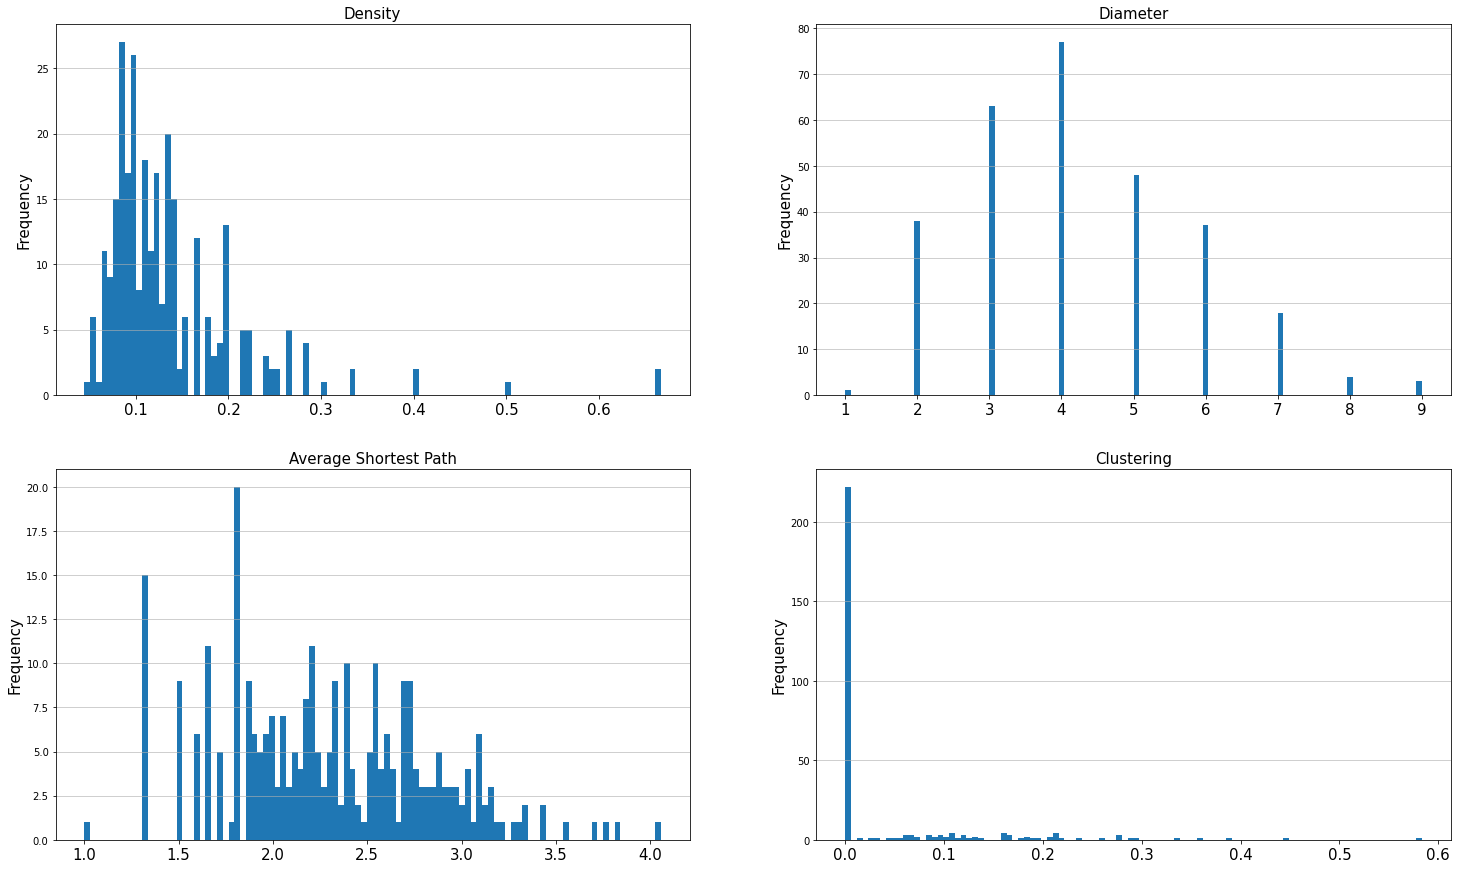

In [25]:
# ----------- Histogram -----------
# Density, Diameter, Average Shortest Path, Clustering,
fig = plt.figure(figsize=(25, 15))
# Density
ax = plt.subplot(2, 2, 1)
plt.hist(df.density, bins=100)
plt.grid(axis='y', alpha=0.75)
plt.ylabel('Frequency', fontsize=15)
plt.xticks(fontsize=15)
plt.title('Density', fontsize=15)
#
# Diameter
ax = plt.subplot(2, 2, 2)
plt.hist(df.diameter, bins=100)
plt.grid(axis='y', alpha=0.75)
plt.ylabel('Frequency', fontsize=15)
plt.xticks(fontsize=15)
plt.title('Diameter', fontsize=15)
#
# Average Shortest Path
ax = plt.subplot(2, 2, 3)
plt.hist(df.average_shortest_path, bins=100)
plt.grid(axis='y', alpha=0.75)
plt.ylabel('Frequency', fontsize=15)
plt.xticks(fontsize=15)
plt.title('Average Shortest Path', fontsize=15)
#
# Clustering
ax = plt.subplot(2, 2, 4)
plt.hist(df.clustering, bins=100)
plt.grid(axis='y', alpha=0.75)
plt.ylabel('Frequency', fontsize=15)
plt.xticks(fontsize=15)
plt.title('Clustering', fontsize=15)
#
# Save figure
output_dir = '/Users/CN/Dropbox/speech_graphs/all_tats/figures/'
output = op.join(output_dir, 'Hist_UndirectedGraphProperties' +
                 '_{0}'.format(str(datetime.date.today())))
plt.savefig(output)
plt.show(block=False)

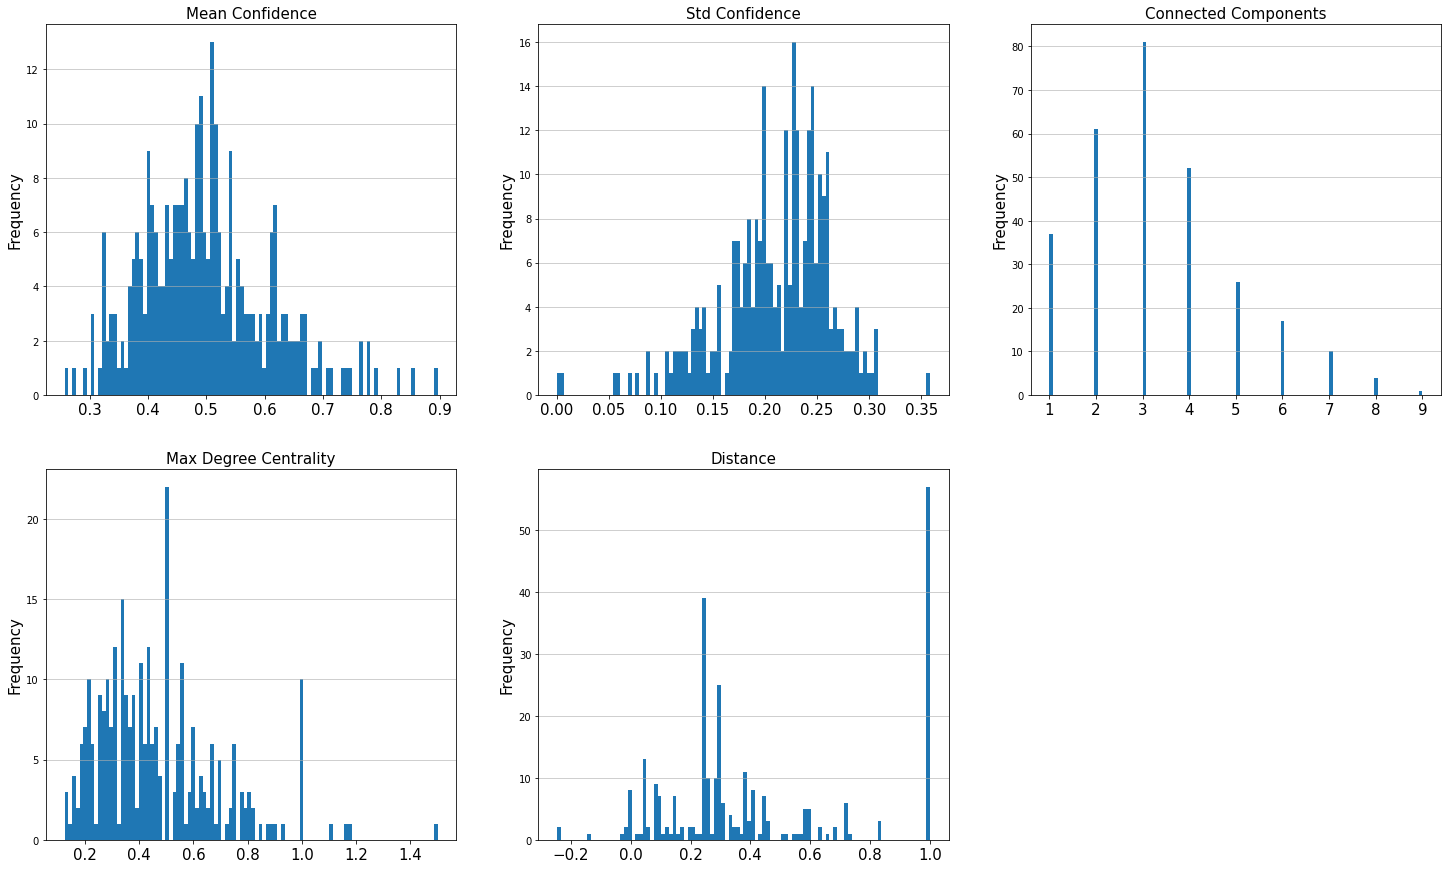

In [26]:

# ----------- Histogram -----------
# Mean Confidence, Std Confidence, Connected Components, Max Degree Centrality, Distance
fig = plt.figure(figsize=(25, 15))
# Mean Confidence
ax = plt.subplot(2, 3, 1)
plt.hist(df.mean_confidence[~np.isnan(df.mean_confidence)], bins=100)
plt.grid(axis='y', alpha=0.75)
plt.ylabel('Frequency', fontsize=15)
plt.xticks(fontsize=15)
plt.title('Mean Confidence', fontsize=15)
#
# Std Confidence
ax = plt.subplot(2, 3, 2)
plt.hist(df.std_confidence[~np.isnan(df.std_confidence)], bins=100)
plt.grid(axis='y', alpha=0.75)
plt.ylabel('Frequency', fontsize=15)
plt.xticks(fontsize=15)
plt.title('Std Confidence', fontsize=15)
#
# Connected Components
ax = plt.subplot(2, 3, 3)
plt.hist(df.connected_components, bins=100)
plt.grid(axis='y', alpha=0.75)
plt.ylabel('Frequency', fontsize=15)
plt.xticks(fontsize=15)
plt.title('Connected Components', fontsize=15)
#
# Max Degree Centrality
ax = plt.subplot(2, 3, 4)
plt.hist(df.max_degree_centrality, bins=100)
plt.grid(axis='y', alpha=0.75)
plt.ylabel('Frequency', fontsize=15)
plt.xticks(fontsize=15)
plt.title('Max Degree Centrality', fontsize=15)
#
# Distance
ax = plt.subplot(2, 3, 5)
plt.hist(df.distance[~np.isnan(df.distance)], bins=100)
plt.grid(axis='y', alpha=0.75)
plt.ylabel('Frequency', fontsize=15)
plt.xticks(fontsize=15)
plt.title('Distance', fontsize=15)
# Save figure
output_dir = '/Users/CN/Dropbox/speech_graphs/all_tats/figures/'
output = op.join(output_dir, 'Hist_' +
                 '_{0}'.format(str(datetime.date.today())))
plt.savefig(output)
plt.show(block=False)

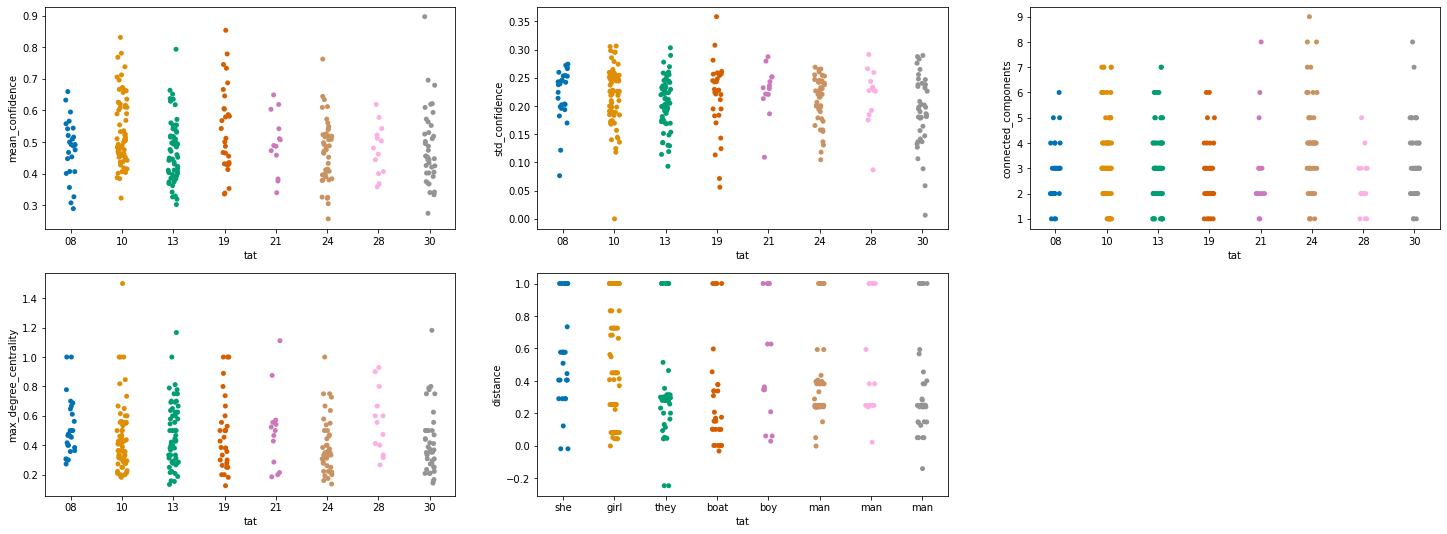

In [29]:
# ----------- stripplot for each TAT -----------
# Mean Confidence, Std Confidence, Connected Components, Max Degree Centrality, Distance
fig = plt.figure(figsize=(25, 9))
ax = plt.subplot(2, 3, 1)
sns.stripplot(y='mean_confidence', x='tat',
              data=df,
              palette="colorblind",
              )
ax = plt.subplot(2, 3, 2)
sns.stripplot(y='std_confidence', x='tat',
              data=df,
              palette="colorblind",
              )
ax = plt.subplot(2, 3, 3)
sns.stripplot(y='connected_components', x='tat',
              data=df,
              palette="colorblind",
              )
ax = plt.subplot(2, 3, 4)
sns.stripplot(y='max_degree_centrality', x='tat',
              data=df,
              palette="colorblind",
              )
ax = plt.subplot(2, 3, 5)
sns.stripplot(y='distance', x='tat',
              data=df,
              palette="colorblind",
              )
ax.set_xticklabels(frequent_words)

output_dir = '/Users/CN/Dropbox/speech_graphs/all_tats/figures/'
output = op.join(output_dir, 'Hist_TAT_noTicks' +
                 '_{0}'.format(str(datetime.date.today())))
plt.savefig(output)
plt.show(block=False)

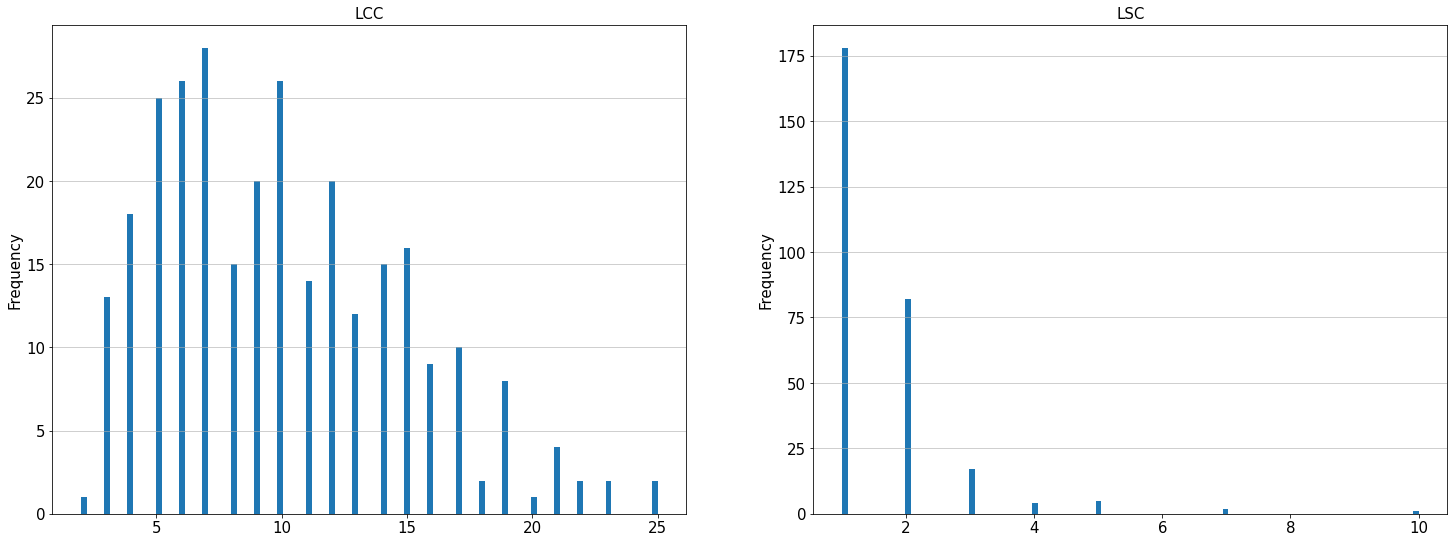

In [30]:

# ----------- Hist -----------
# LCC & LSC
fig = plt.figure(figsize=(25, 9))
# ---- LCC ----
# Set up the plot
ax = plt.subplot(1, 2, 1)
plt.hist(df.lcc, bins=100)
plt.grid(axis='y', alpha=0.75)
# plt.xlabel('Nodes', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.title('LCC', fontsize=15)
# ---- LSC ----
# Set up the plot
ax = plt.subplot(1, 2, 2)
plt.hist(df.lsc, bins=100)
plt.grid(axis='y', alpha=0.75)
# plt.xlabel('Nodes', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.title('LSC', fontsize=15)
output_dir = '/Users/CN/Dropbox/speech_graphs/all_tats/figures/'
output = op.join(output_dir, 'Hist_LCC-LSC' +
                 '_{0}'.format(str(datetime.date.today())))
plt.savefig(output)
plt.show(block=False)

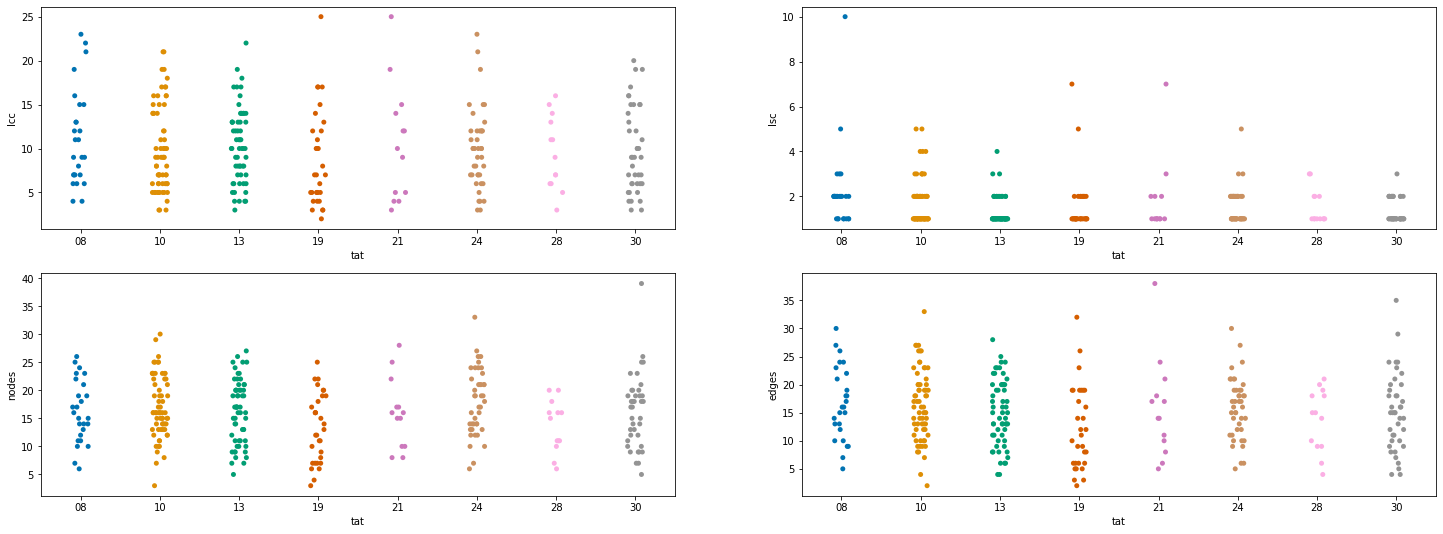

In [31]:
# ----------- LCC, LSC, Nodes, Edges by TAT -----------
fig = plt.figure(figsize=(25, 9))
ax = plt.subplot(2, 2, 1)
sns.stripplot(y='lcc', x='tat',
              data=df,
              palette="colorblind",
              )
ax = plt.subplot(2, 2, 2)
sns.stripplot(y='lsc', x='tat',
              data=df,
              palette="colorblind",
              )
ax = plt.subplot(2, 2, 3)
sns.stripplot(y='nodes', x='tat',
              data=df,
              palette="colorblind",
              )
ax = plt.subplot(2, 2, 4)
sns.stripplot(y='edges', x='tat',
              data=df,
              palette="colorblind",
              )
output_dir = '/Users/CN/Dropbox/speech_graphs/all_tats/figures/'
output = op.join(output_dir, 'Hist_LCC-LSC_TAT' +
                 '_{0}'.format(str(datetime.date.today())))
plt.savefig(output)
plt.show(block=False)

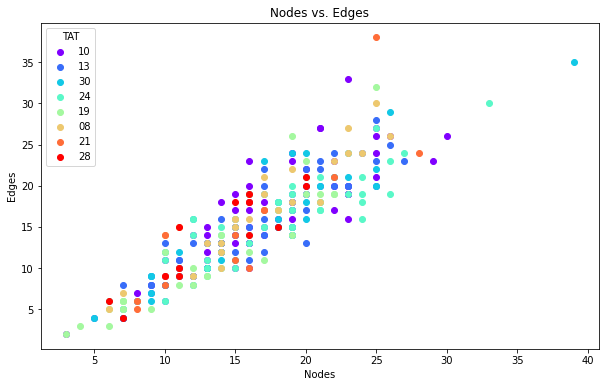

In [32]:

# ----------- Plot nodes vs edges -----------
fig, ax = plt.subplots(figsize=(10, 6))
tats = df.tat.unique()
colors = cm.rainbow(np.linspace(0, 1, len(tats)))
for t, c in zip(tats, colors):
    plt.scatter(df[df.tat == t].nodes, df[df.tat == t].edges, color=c, label=t)

ax.legend(title="TAT")
plt.title('Nodes vs. Edges')
plt.xlabel('Nodes')
plt.ylabel('Edges')
output_dir = '/Users/CN/Dropbox/speech_graphs/all_tats/figures/'
output = op.join(output_dir, 'Nodes_vs_Edges' +
                 '_{0}'.format(str(datetime.date.today())))
plt.savefig(output)
plt.show(block=False)

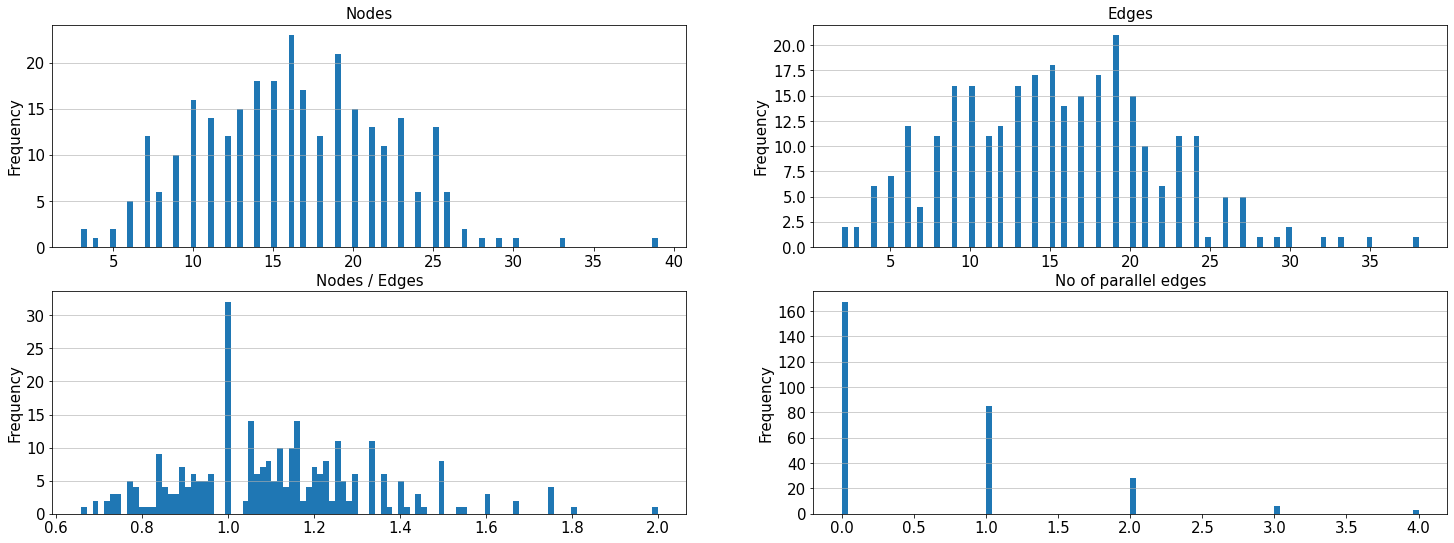

In [33]:

# ----------- Histogram: Nodes, Edges, Node-Edge ratio, Parallel edges -----------
# Set up the plot
fig = plt.figure(figsize=(25, 9))
# Nodes
ax = plt.subplot(2, 2, 1)
plt.hist(df.nodes, bins=100)
plt.grid(axis='y', alpha=0.75)
plt.ylabel('Frequency', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Nodes', fontsize=15)
# Edges
ax = plt.subplot(2, 2, 2)
plt.hist(df.edges, bins=100)
plt.grid(axis='y', alpha=0.75)
plt.ylabel('Frequency', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Edges', fontsize=15)
# Histogram Nodes/Edges ratio
ax = plt.subplot(2, 2, 3)
plt.hist(df.nodes / df.edges, bins=100)
plt.grid(axis='y', alpha=0.75)
plt.ylabel('Frequency', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Nodes / Edges', fontsize=15)
# Parallel edges
ax = plt.subplot(2, 2, 4)
plt.hist(df.parallel_edges, bins=100)
plt.grid(axis='y', alpha=0.75)
plt.ylabel('Frequency', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('No of parallel edges', fontsize=15)
# Save
output_dir = '/Users/CN/Dropbox/speech_graphs/all_tats/figures/'
output = op.join(output_dir, 'Hist_LCC-LSC_TAT' +
                 '_{0}'.format(str(datetime.date.today())))
plt.savefig(output)
plt.show(block=False)